In [1]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import warnings
from utils import *
sns.set_theme(style="darkgrid", palette="pastel")
sns.color_palette("Set2")
warnings.filterwarnings("ignore")

df = pd.read_csv("data/data.csv") 
df.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Scenario 1: Trying alternative scenario of working with '>' and '<' symbols.

In [2]:
columns_with_comparators = ['experience','last_new_job']
for col in columns_with_comparators:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.drop(columns=['enrollee_id','city'],axis=1)
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,NaN,NaN,NaN,1.0,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,NaN,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,NaN,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,NaN,NaN,Pvt Ltd,NaN,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,NaN,50-99,Funded Startup,4.0,8,0.0


F1 Score: 0.9193324061196105


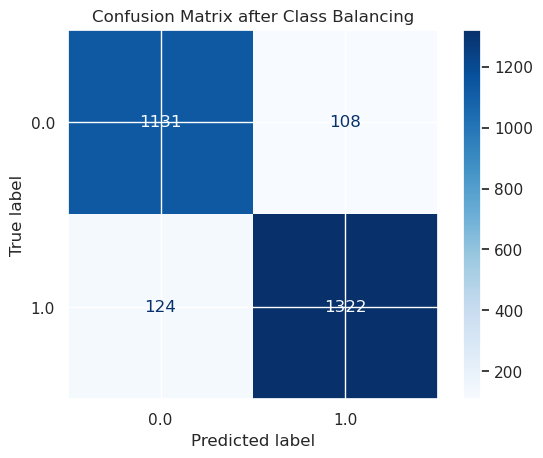

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      1239
         1.0       0.92      0.91      0.92      1446

    accuracy                           0.91      2685
   macro avg       0.91      0.91      0.91      2685
weighted avg       0.91      0.91      0.91      2685



In [3]:
from imblearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
from category_encoders import TargetEncoder
from reparo import MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

te = TargetEncoder(handle_missing='return_nan');
si = SimpleImputer(strategy='most_frequent');
smt = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
rf = RandomForestClassifier(class_weight='balanced')

y = df['target']
X = df.drop('target', axis=1)

pipeline = Pipeline(steps=[('target_encoding', te),
                           ('imputer', si),
                            ('smoteenn', smt),
                          ])

X_res, y_res = pipeline.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Blues')
plt.title(f"Confusion Matrix after Class Balancing")
plt.show()

print(classification_report(y_test, predictions))

Now we see that using a replacement with nan, and after that using MICE() or SimpleImputer(), lowers down the accuracy of the model.

**Note**: Forced to work with SimpleImputer from sklearn because as I observed MICE() from reparo does not support pipelines

## Scenario 2: Trying to replace TargetEncoder with a OneHotEncoder

In [4]:
df = pd.read_csv("data.csv") 
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Data Preprocessing

In [5]:
def convert_thresholds(x):
    if x is None:
        return None

    if isinstance(x, int):
        return x

    if isinstance(x, float):
        if math.isnan(x):
            return None
        return int(x)

    if isinstance(x, str):
        if x == 'never':
            x = 0
        elif '>' in x:
            x = int(x.split('>')[-1]) + 1
        elif '<' in x:
            x = int(x.split('<')[-1]) - 0.5
        else:
            x = int(x.strip())

    return x

df['experience'] = df['experience'].map(convert_thresholds)
df['last_new_job'] = df['last_new_job'].map(convert_thresholds)

F1 Score: 0.9795293667495695


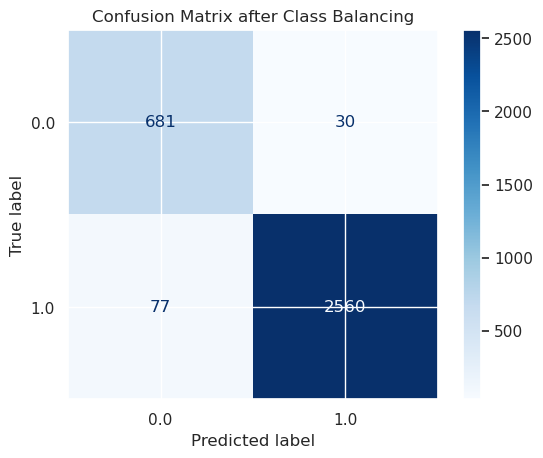

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       711
         1.0       0.99      0.97      0.98      2637

    accuracy                           0.97      3348
   macro avg       0.94      0.96      0.95      3348
weighted avg       0.97      0.97      0.97      3348



In [6]:
from sklearn.preprocessing import OneHotEncoder
df_test = df

df.drop(columns=['enrollee_id', 'city'], inplace=True)

ohe = OneHotEncoder();
si = SimpleImputer(strategy='most_frequent');
smt = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
rf = RandomForestClassifier(class_weight='balanced')

y = df['target']
X = df.drop('target', axis=1)

pipeline = Pipeline(steps=[('one_hot', ohe),
                           ('imputer', si),
                           ('smoteenn', smt),
                          ])

X_res, y_res = pipeline.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Blues')
plt.title(f"Confusion Matrix after Class Balancing")
plt.show()

print(classification_report(y_test, predictions))

After working with pipelines, we got pretty good results, however the dataset even after SMOTEENN is pretty unbalanced.

In [7]:
print("Number of features after OneHotEncoder:", X_res.shape[1])

Number of features after OneHotEncoder: 403


This number of features take a lot of time and resources for a model to train, and also not all of them are necessary.

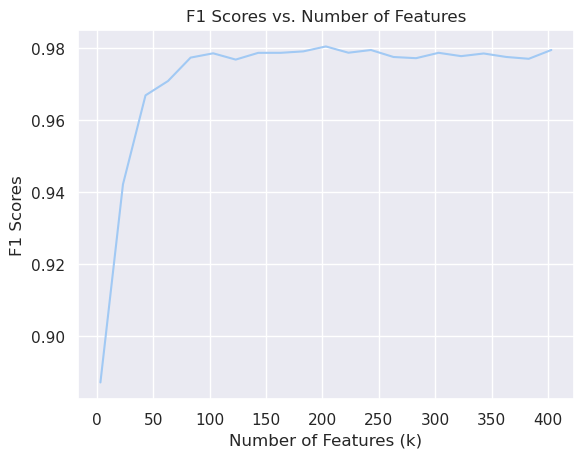

In [8]:
from sklearn.feature_selection import SelectKBest, chi2
rf = RandomForestClassifier(class_weight='balanced')


def calculate_f1_kbest(X, y, classifier):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    f1_scores = []
    k_values = range(3, 403 + 1, 20)

    for k in k_values:
        selected_features = SelectKBest(score_func = chi2, k=k).fit(X_train, y_train)
        X_train_selected = selected_features.transform(X_train)
        X_test_selected = selected_features.transform(X_test)
        classifier.fit(X_train_selected, y_train)

        y_pred = classifier.predict(X_test_selected)
        f1 = f1_score(y_test, y_pred)

        f1_scores.append(f1)
    return k_values, f1_scores

k_values, f1_scores = calculate_f1_kbest(X_res, y_res, rf)
plt.plot(k_values, f1_scores)
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs. Number of Features')
plt.show()

As seen, on about 200 features, the f1 score start to stabilize thus in the last pipeline we will do k = 200.

F1 Score: 0.9772510036321926


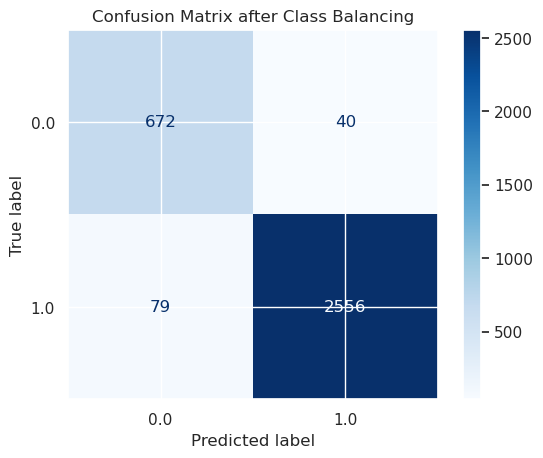

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       712
         1.0       0.98      0.97      0.98      2635

    accuracy                           0.96      3347
   macro avg       0.94      0.96      0.95      3347
weighted avg       0.97      0.96      0.96      3347



In [11]:
df = df_test
df.drop(columns=['enrollee_id', 'city'], inplace=True)

ohe = OneHotEncoder();
si = SimpleImputer(strategy='most_frequent');
smt = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

y = df['target']
X = df.drop('target', axis=1)

pipeline_1 = Pipeline(steps=[('one_hot', ohe),
                           ('imputer', si),
                            ('smoteenn', smt),
                          ])

X_res, y_res = pipeline_1.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

kb = SelectKBest(score_func=chi2,k=200)
rf = RandomForestClassifier(class_weight='balanced')
pipeline_2 = Pipeline(steps=[('kbest', kb),
                             ('rf',rf),
                            ])

pipeline_2.fit(X_train,y_train)

predictions=pipeline_2.predict(X_test)

f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Blues')
plt.title(f"Confusion Matrix after Class Balancing")
plt.show()

print(classification_report(y_test, predictions))

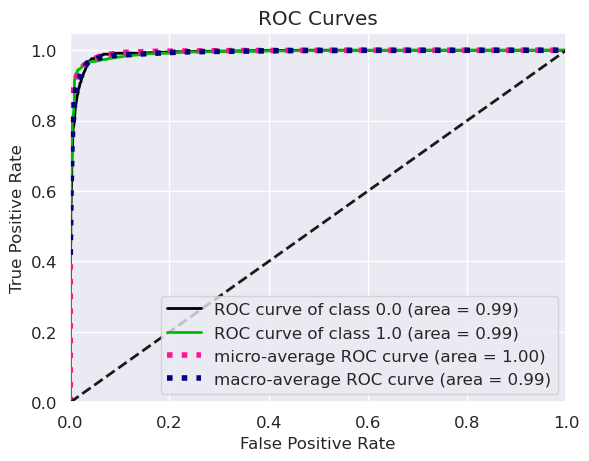

In [12]:
import scikitplot as skplt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

y_pred_proba = pipeline_2.predict_proba(X_test)

plot = skplt.metrics.plot_roc(y_test, y_pred_proba)

After analysing final scores and ROC AUC, we can say that results are pretty good, however it is pretty understandable that the model is unbalanced and it will not behave respectively on new datasets. Thus we can come to the conclusion that the OneHotEncoder is not the best solution for this kind of dataset.